# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import scipy.ndimage as ndi
import matplotlib.pyplot as plt

from data import data_helper
from data.data_helper import Phase

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.exceptions import ConvergenceWarning

## Model Choice

Diagnosis of the wanted disease is normally made based on structural characteristics, such as ventricle volumes and myocard thickness.
Since segmentation masks are given, they can be used to calculate these metrics directly and use them as features for a classical ML model, e.g. a SVM


## Feature Selection

[Indicate which features from the dataset you will be using for the baseline model, and justify your selection.]


In [3]:
def compute_MC_thickness(lv_mask, myo_mask, voxel_spacing=(1.,1.,1.),
                          num_angles=360, num_slices=None):
    """
    Computes myocardial thickness in 3D using polar coordinates. Uses RAS+ space.

    Parameters:
    - lv_mask: 3D binary NumPy array of the left ventricle (LV) segmentation mask
    - myo_mask: 3D binary NumPy array of the myocardium segmentation mask
    - voxel_spacing: Tuple (dR, dS, dA) representing the voxel spacing in mm
    - num_angles: Number of angles for the polar sampling (default: 360)
    - num_slices: Number of slices to process (default: all)

    Returns:
    - thickness_map: 3D array with myocardial thickness values (in mm)
    - mean_thickness: Average myocardial thickness (in mm)
    """

    # Get image dimensions
    height, width, depth = lv_mask.shape

    # If num_slices is specified, process only a subset
    if num_slices is not None:
        slice_indices = np.linspace(0, depth - 1, num_slices, dtype=int)
    else:
        slice_indices = range(depth)

    # Initialize thickness map
    thickness_map = np.zeros((len(slice_indices), num_angles), dtype=np.float32)

    # Iterate over selected slices
    for z in slice_indices:
        # Extract single slice masks
        lv_slice = lv_mask[:, :, z]
        myo_slice = myo_mask[:, :, z]

        # Compute LV centroid
        y_coords, x_coords = np.where(lv_slice > 0)
        if len(x_coords) == 0 or len(y_coords) == 0:
            continue  # Skip slices without LV segmentation
        lv_center = (np.mean(x_coords), np.mean(y_coords))  # (x, y) center

        # Compute distance transforms for inner and outer boundaries
        dist_inner = ndi.distance_transform_edt(lv_slice) # , sampling=voxel_spacing[:1]
        dist_outer = ndi.distance_transform_edt((lv_slice | myo_slice))

        # Get boundary masks
        lv_boundary = np.where((dist_inner == 1), 1, 0)
        myo_boundary = np.where((dist_outer == 1), 1, 0)

        # Convert to polar coordinates
        angles = np.linspace(0, 2 * np.pi, num_angles)

        for k, theta in enumerate(angles):
            dx = np.cos(theta)
            dy = np.sin(theta)

            inner_radii = []
            outer_radii = []

            for r in range(1, max(height, width)):  # Extend ray outward
                x = int(lv_center[0] + r * dx)
                y = int(lv_center[1] + r * dy)

                if 0 <= x < width and 0 <= y < height:
                    if lv_boundary[y, x]:  # Inner boundary hit
                        inner_radii.append(r * voxel_spacing[0]) # r * voxel_spacing[2]?
                    if myo_boundary[y, x]:  # Outer boundary hit
                        outer_radii.append(r * voxel_spacing[0])


            if inner_radii and outer_radii:
                thickness_map[z, k] = np.min(outer_radii) - np.min(inner_radii)

    return angles, thickness_map


# compute the volume by summing up the segmented voxels
def compute_volumes(mask, voxel_spacing=(1,1,1)):
    voxel_volume = np.prod(voxel_spacing)
    vol = voxel_volume * np.sum(mask > 0)
    vol /= 1000.  # convert to cm3
    return vol

In [4]:
train_data = data_helper.load_all_patients('../data/train', load_imgs=True, return_df=True)
mask_labels = ['RV', 'MC', 'LV']

In [5]:
features = []
for _, subj in train_data.iterrows():
    subj_features = {'label': subj['label']}
    for phase in [Phase.SYS, Phase.DIA]:
        seg_mask = subj[f'{phase}_seg']
        spacing = subj[f'{phase}_seg_header'].get_zooms()
        for k, mask_label in enumerate(mask_labels):
            volume = compute_volumes(seg_mask==k+1, spacing)
            subj_features[f'{mask_label}_{phase}'] = volume
        lv_mask = (seg_mask==2)
        myo_mask = (seg_mask==3)
        _, myo_thickness = compute_MC_thickness(lv_mask, myo_mask, spacing)
        subj_features[f'{phase}_max_myo_thickness'] = np.max(myo_thickness)
        subj_features[f'{phase}_mean_myo_thickness'] = np.mean(myo_thickness)
    features.append(subj_features)
features_df = pd.DataFrame(features)
features_df['SV'] = features_df['LV_sys'] - features_df['LV_dia']
features_df['EF'] = features_df['SV'] / features_df['LV_sys']

display(features_df.groupby('label').mean().round(1))

,RV_sys,MC_sys,LV_sys,sys_max_myo_thickness,sys_mean_myo_thickness,RV_dia,MC_dia,LV_dia,dia_max_myo_thickness,dia_mean_myo_thickness,SV,EF
label,,,,,,,,,,,,
DCM,186.1,158.0,275.6,12.400000,4.7,128.6,168.5,224.9,14.700000,5.6,50.7,0.2
HCM,121.2,167.9,127.9,22.200001,7.3,47.7,192.4,42.0,26.900000,10.3,86.0,0.7
MINF,126.2,129.2,189.3,13.600000,4.8,58.3,143.4,131.8,18.400000,6.4,57.5,0.3
NOR,147.7,94.1,130.8,11.400000,4.2,69.2,109.0,51.0,16.799999,6.9,79.9,0.6
RV,220.6,81.6,125.5,11.400000,3.7,139.6,91.0,54.0,15.500000,5.8,71.5,0.6


<Axes: >

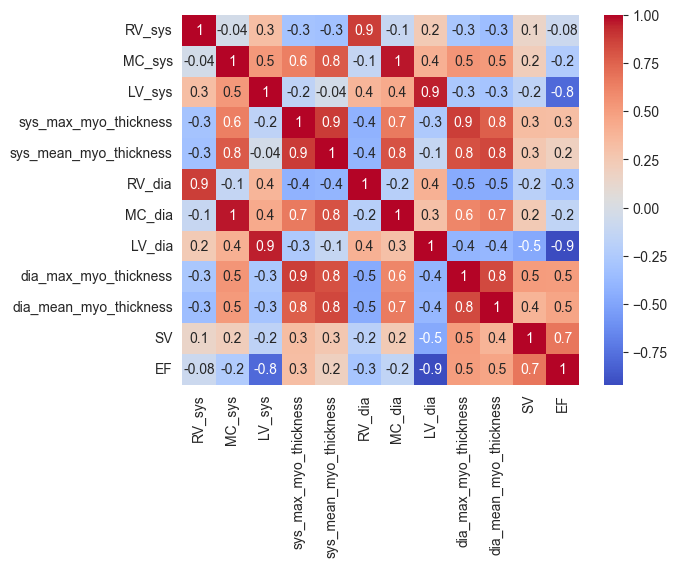

In [6]:
import seaborn as sns
sns.heatmap(features_df.corr(numeric_only=True), cmap='coolwarm', annot=True, fmt='.1g')

## Implementation

[Implement your baseline model here.]



In [18]:
# Let's first try a simple SVM model

# Prepare the data
X = features_df.drop(columns=['label'])
y = features_df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

classifier = SVC(kernel='rbf', random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         DCM       0.60      0.75      0.67         4
         HCM       1.00      0.75      0.86         4
        MINF       0.67      0.50      0.57         4
         NOR       0.67      1.00      0.80         4
          RV       1.00      0.75      0.86         4

    accuracy                           0.75        20
   macro avg       0.79      0.75      0.75        20
weighted avg       0.79      0.75      0.75        20



This is already pretty good! Let's test some other models and use GridSearchCV to find a good one

In [7]:
import warnings
# comment out the next line to see ConvergenceWarnings
warnings.simplefilter('ignore', category=ConvergenceWarning)

# Assuming 'df' is already created as in the provided code.
# Prepare the data
X = features_df.drop(['label'], axis=1)
y = features_df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the classifiers and their parameter grids
classifiers = {
    'LogisticRegression': (LogisticRegression(random_state=42, max_iter=10000, tol=0.1),
                           {'classifier__C': np.logspace(-3, 3, 7),}),
    'SVM': (SVC(random_state=42),
            {'classifier__C': [0.01, 0.1, 1, 10, 100], 'classifier__kernel': ['linear', 'rbf', 'poly']}),
    'DecisionTree': (DecisionTreeClassifier(random_state=42),
                     {'classifier__criterion': ['gini', 'entropy'],
                      'classifier__max_depth': [None, 5, 10, 20]}),
    'RandomForest': (RandomForestClassifier(random_state=42),
                     {'classifier__n_estimators': [10, 25, 50],
                      'classifier__max_depth': [None, 5, 10, 20]}),
    'GradientBoosting': (GradientBoostingClassifier(random_state=42),
                         {'classifier__n_estimators': [10, 25, 50],
                          'classifier__learning_rate': [0.01, 0.1, 1]}),
    'MLPClassifier': (MLPClassifier(random_state=42, max_iter=500), # Increased max_iter
                      {'classifier__hidden_layer_sizes': [(32), (64), (16,32), (32,64)],
                       'classifier__alpha': [0.0001, 0.001]})
}

# Perform stratified k-fold cross-validation and grid search
best_classifier = None
best_score = 0
best_model = None


for name, (classifier, param_grid) in classifiers.items():
    pipeline = Pipeline([
        ('scaler', 'MinMaxScaler'),  # Use MinMaxScaler for feature scaling
        ('reducer', 'passthrough'),
        ('classifier', classifier)
    ])
    # add different normalization schemes to the grid search
    param_grid = dict(**param_grid,
                      scaler = [MinMaxScaler(), StandardScaler(), 'passthrough'],
                      reducer = [PCA(3), PCA(5), 'passthrough'])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1_weighted')  # Use f1_weighted as the scoring metric
    grid_search.fit(X_train, y_train)

    print(f"Results for {name}:")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

    if grid_search.best_score_ > best_score:
      best_score = grid_search.best_score_
      best_model = grid_search.best_estimator_
      best_classifier = name


print(f"\nBest classifier: {best_classifier}")

# Evaluate the best classifier on the test set
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Results for LogisticRegression:
Best parameters: {'classifier__C': 1.0, 'reducer': PCA(n_components=5), 'scaler': MinMaxScaler()}
Best cross-validation score: 0.872
Results for SVM:
Best parameters: {'classifier__C': 10, 'classifier__kernel': 'linear', 'reducer': 'passthrough', 'scaler': MinMaxScaler()}
Best cross-validation score: 0.937
Results for DecisionTree:
Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'reducer': PCA(n_components=5), 'scaler': 'passthrough'}
Best cross-validation score: 0.875
Results for RandomForest:
Best parameters: {'classifier__max_depth': 5, 'classifier__n_estimators': 50, 'reducer': PCA(n_components=3), 'scaler': 'passthrough'}
Best cross-validation score: 0.912
Results for GradientBoosting:
Best parameters: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 25, 'reducer': PCA(n_components=3), 'scaler': 'passthrough'}
Best cross-validation score: 0.840
Results for MLPClassifier:
Best parameters: {'classifier__

## Evaluation

[Clearly state what metrics you will use to evaluate the model's performance. These metrics will serve as a starting point for evaluating more complex models later on.]



In [8]:
# Evaluate the best classifier on the test set
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         DCM       0.57      1.00      0.73         4
         HCM       1.00      0.75      0.86         4
        MINF       1.00      0.25      0.40         4
         NOR       0.80      1.00      0.89         4
          RV       1.00      1.00      1.00         4

    accuracy                           0.80        20
   macro avg       0.87      0.80      0.77        20
weighted avg       0.87      0.80      0.77        20



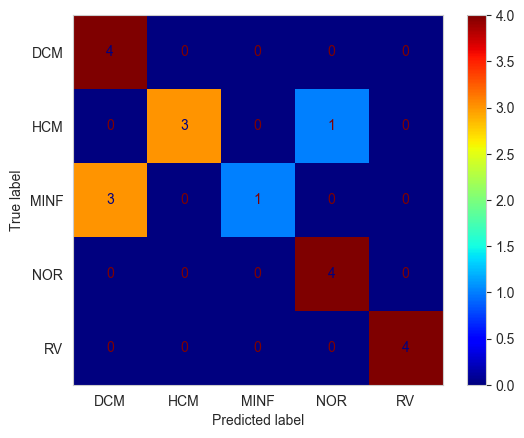

In [23]:
#confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='jet')
plt.grid(False)
plt.show()

In [28]:
test_data = data_helper.load_all_patients('../data/test', load_imgs=True, return_df=True)

In [29]:
test_data.iloc[18].to_dict()

{'sys': array([[[  4.,   4.,   4., ...,   1.,   0.,   0.],
         [  4.,   4.,   4., ...,   1.,   0.,   0.],
         [  4.,   4.,   4., ...,   1.,   0.,   0.],
         ...,
         [  4.,   4.,   4., ...,   1.,   0.,   0.],
         [  4.,   4.,   4., ...,   1.,   0.,   0.],
         [  4.,   4.,   4., ...,   1.,   0.,   0.]],
 
        [[  4.,   4.,   4., ...,   1.,   0.,   0.],
         [  5.,   6.,   8., ...,   2.,   0.,   0.],
         [  7.,   8.,  10., ...,   2.,   1.,   1.],
         ...,
         [  5.,   5.,   5., ...,   1.,   0.,   0.],
         [  5.,   5.,   5., ...,   1.,   0.,   0.],
         [  5.,   5.,   5., ...,   2.,   0.,   0.]],
 
        [[  4.,   4.,   4., ...,   1.,   0.,   0.],
         [  5.,   6.,   8., ...,   4.,   0.,   1.],
         [  6.,   6.,   9., ...,   2.,   1.,   2.],
         ...,
         [  6.,   6.,   5., ...,   2.,   0.,   0.],
         [  5.,   5.,   5., ...,   1.,   0.,   0.],
         [  5.,   5.,   6., ...,   2.,   0.,   0.]],
 
      

In [37]:
features = []
for sid, subj in test_data.iterrows():
    print(sid)
    subj_features = {'id': sid}
    for phase in [Phase.SYS, Phase.DIA]:
        seg_mask = subj[f'{phase}_seg']
        spacing = subj[f'{phase}_header'].get_zooms()
        for k, mask_label in enumerate(mask_labels):
            volume = compute_volumes(seg_mask==k+1, spacing)
            subj_features[f'{mask_label}_{phase}'] = volume
        lv_mask = (seg_mask==2)
        myo_mask = (seg_mask==3)
        _, myo_thickness = compute_MC_thickness(lv_mask, myo_mask, spacing)
        subj_features[f'{phase}_max_myo_thickness'] = np.max(myo_thickness)
        subj_features[f'{phase}_mean_myo_thickness'] = np.mean(myo_thickness)
    features.append(subj_features)
features_df = pd.DataFrame(features)
features_df['SV'] = features_df['LV_sys'] - features_df['LV_dia']
features_df['EF'] = features_df['SV'] / features_df['LV_sys']

display(features_df.groupby('label').mean().round(1))

p0101
p0102
p0103
p0104
p0105
p0106
p0107
p0108
p0109
p0110
p0111
p0112
p0113
p0114
p0115
p0116
p0117
p0118
p0119
p0120
p0121
p0122
p0123
p0124
p0125
p0126
p0127
p0128
p0129
p0130
p0131
p0132
p0133
p0134
p0135
p0136
p0137
p0138
p0139
p0140
p0141
p0142
p0143
p0144
p0145
p0146
p0147
p0148
p0149
p0150


KeyError: 'label'

In [40]:
y_pred = best_model.predict(features_df.drop(columns=['id']))
pd.Series(y_pred, index=features_df['id'], name='label').to_csv("submission.csv")